# Testing the forward simulation for the experimental setup

In [2]:
import os

###############################################################################
# Decide on CPU or GPU here
use_gpu = True  # Set to False if you want CPU only
###############################################################################

if use_gpu:
    # Prevent JAX from preallocating most of the GPU memory
    os.environ["XLA_PYTHON_CLIENT_PREALLOCATE"] = "false"
    # Force JAX to use GPU
    import jax
    jax.config.update("jax_platform_name", "gpu")
else:
    # Force JAX to use CPU
    import jax
    jax.config.update("jax_platform_name", "cpu")

In [3]:
import numpy as np
from jax import jit, vjp, vmap, value_and_grad, random
import jax
from jax import numpy as jnp
from jax import lax
from jaxdf.operators import compose
from matplotlib import pyplot as plt
from matplotlib.gridspec import GridSpec
from IPython.display import display, clear_output

from cmcrameri import cm

import optax
import equinox as eqx
from jax.example_libraries import optimizers
import time


from jwave.geometry import Domain, Medium
from jwave.signal_processing import smooth

key = random.PRNGKey(42)  # Random seed


from hybridoed.forward import create_src_field, generate_2D_gridded_src_rec_positions, ricker_wavelet, acoustic2D, acoustic2D_pml,acoustic2D_pml_minmem, acoustic2D_pml_4th_minmem, generate_src_rec_positions, acoustic2D_cpml_minmem

from hybridoed.oed import *


2025-10-03 14:42:15.146831: W external/xla/xla/service/gpu/nvptx_compiler.cc:930] The NVIDIA driver's CUDA version is 12.2 which is older than the PTX compiler version 12.5.82. Because the driver is older than the PTX compiler version, XLA is disabling parallel compilation, which may slow down compilation. You should update your NVIDIA driver or use the NVIDIA-provided CUDA forward compatibility packages.


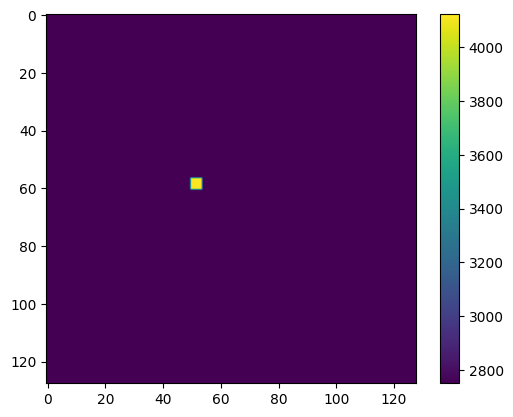

<class 'jaxlib.xla_extension.ArrayImpl'>


In [4]:
# load a model

# constant model
nx, ny = 128, 128  # for testing purpose only

velocity = 2750

true_model = jnp.ones((nx, ny)) * velocity #https://signal-processing.com/table.php

# introduce a scatterer in the true model
true_model = true_model.at[57:61, 50:54].set(velocity * 1.5)


plt.imshow(true_model)
plt.colorbar()
plt.show()
print(type(true_model))


In [5]:
src_coords_list, receiver_coords_list = generate_2D_gridded_src_rec_positions(N=(int(nx*0.225), int(ny*0.45)), num_sources=1, num_receivers=75)


source_positions = (src_coords_list[:, 0] + 54, src_coords_list[:, 1] + 65 )
source_positions = (source_positions[0].astype(float), source_positions[1].astype(float))

sensors_positions = (receiver_coords_list[:,0] + 45, receiver_coords_list[:,1] + 32)

(np.float64(-0.5), np.float64(127.5), np.float64(127.5), np.float64(-0.5))

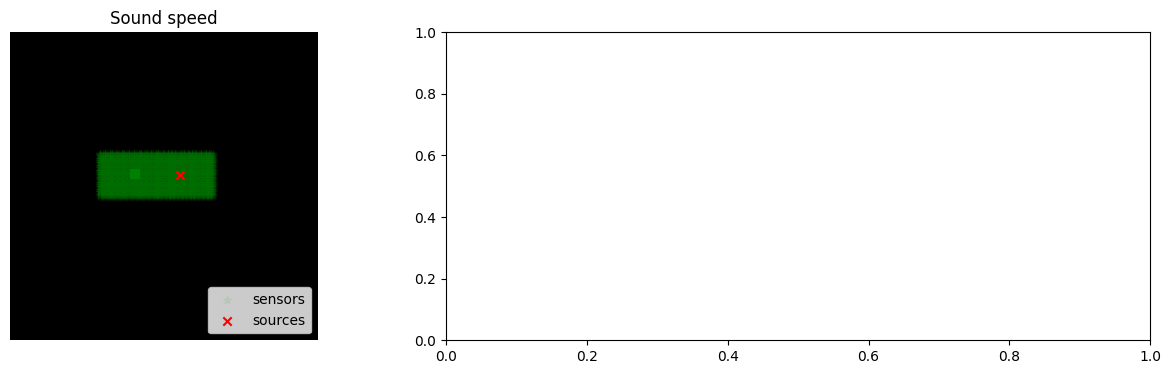

In [6]:
fig, ax = plt.subplots(1, 2, figsize=(15, 4), gridspec_kw={"width_ratios": [1, 2]})
ax[0].scatter(
    sensors_positions[1], sensors_positions[0], c="g", marker="*", label="sensors", alpha=0.05
)
ax[0].imshow(true_model, cmap="gray")
ax[0].scatter(
    source_positions[1], source_positions[0], c="r", marker="x", label="sources"
)

ax[0].legend(loc="lower right")
ax[0].set_title("Sound speed")
ax[0].axis("off")

In [7]:
f0 = 25e3 #Hz
# calculate dx, dy, dt based on the model and f0
dx = dy = velocity / (10 * 2*f0)  # spatial step (m)
dt = 0.25 * dx / velocity  # time step (s) (CFL condition)

print(f"dx = dy = {dx*1e3} mm")
print(f"dt = {dt*1e6} µs")

n_steps_forward = 1200

density = jnp.ones_like(true_model) * 1000.0
pml_width = 12

# transform the sensors positions to the the same format as the receiver_is
receiver_is_modif = jnp.stack([sensors_positions[0], sensors_positions[1]], axis=-1)
source_modif = jnp.stack([source_positions[0], source_positions[1]], axis=-1)
num_sources = source_modif.shape[0]


# p_test, wavefields_test = acoustic2D_pml_minmem(true_model, density, source_modif[0], f0, dx, dy, dt, n_steps_forward, receiver_is_modif, pml_width=pml_width)

p_test, wavefields_test = acoustic2D_cpml_minmem(true_model, density, source_modif[0], f0, dx, dy, dt, n_steps_forward, receiver_is_modif, pml_width=pml_width)

dx = dy = 5.5 mm
dt = 0.5 µs


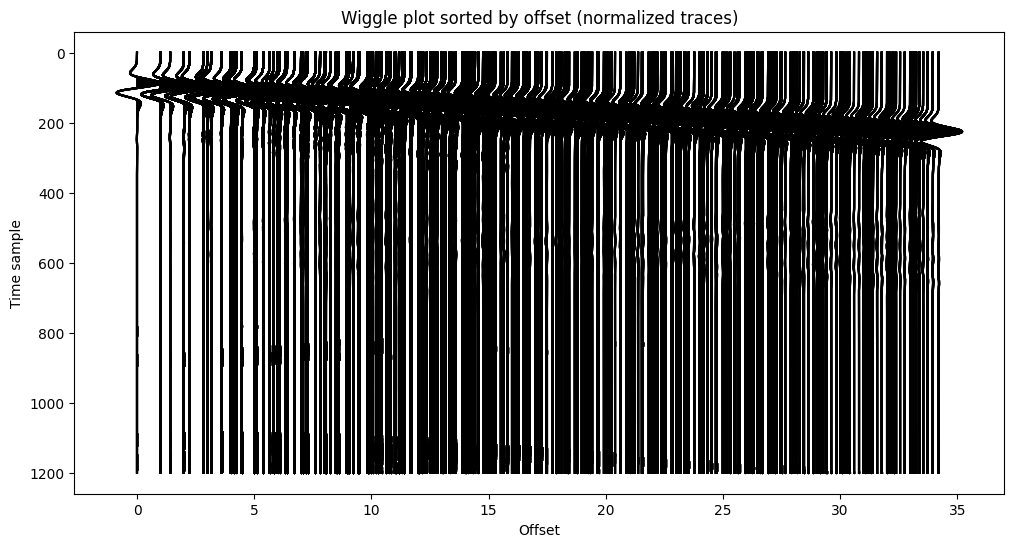

In [8]:
# Wiggle plot for p_test (gather) with each trace normalized and sorted by offset
scale = 1  # Adjust for visual clarity
source_x, source_y = source_modif[0]
receiver_x, receiver_y = receiver_is_modif[:,0], receiver_is_modif[:,1]
offsets = np.sqrt((receiver_x - source_x)**2 + (receiver_y - source_y)**2)
sorted_indices = np.argsort(offsets)
sorted_offsets = offsets[sorted_indices]
sorted_traces = p_test[:, sorted_indices]
n_traces = sorted_traces.shape[1]
n_samples = sorted_traces.shape[0]




plt.figure(figsize=(12, 6))
for i in range(n_traces):
    trace = sorted_traces[:, i]
    norm_trace = trace / (np.max(np.abs(trace)) + 1e-12)
    # norm_trace = trace
    plt.plot(norm_trace * scale + sorted_offsets[i], np.arange(n_samples), color='k')
    plt.fill_betweenx(np.arange(n_samples), sorted_offsets[i], norm_trace * scale + sorted_offsets[i], where=(norm_trace > 0), color='k', alpha=0.5)
plt.gca().invert_yaxis()
plt.xlabel('Offset')
plt.ylabel('Time sample')
plt.title('Wiggle plot sorted by offset (normalized traces)')
plt.show()


In [9]:


# ---- physical domain (meters) ----
Lx, Ly = 0.4, 0.4               # FIXED domain size
c_min = c_max = 2750.0            # plexiglass (m/s)

# ---- resolution chosen ONCE for the highest test frequency ----
f0_max = 25e3                     # highest center freq you'll run
fmax   = 2.0 * f0_max             # Ricker top-end
PPW    = 10                       # for 2nd-order space; 10–12 is typical

dx_req = c_min / (PPW * fmax)
dx = dy = dx_req                  # keep this fixed for all runs

# grid size from physical size
nx = int(np.floor(Lx / dx)) + 1
ny = int(np.floor(Ly / dy)) + 1
dx = Lx / (nx - 1)                # snap dx to fit exactly
dy = Ly / (ny - 1)

print(f"nx, ny = {nx}, {ny}  |  dx = {dx*1e3:.2f} mm, dy = {dy*1e3:.2f} mm")

# ---- stable time step (keep FIXED) ----
dt_max = min(dx,dy) / (c_max * np.sqrt(2.0))   # 2-D CFL for staggered first-order
dt = 0.8 * dt_max                              # margin
print(f"dt = {dt*1e6:.2f} µs")

# ---- PML thickness in METERS (fixed), converted to cells ----
pml_thickness_m = 0.1                         # e.g., 3 cm per side
pml_width = max(4, int(round(pml_thickness_m / dx)))
print(f"pml_width = {pml_width} cells (~{pml_width*dx*100:.1f} cm)")

# ---- material model (fixed in meters) ----
velocity = 2750.0
density  = 1000.0

true_model = jnp.full((nx, ny), velocity, dtype=jnp.float32)

# scatterer defined in METERS, then mapped to indices
scx0, scx1 = 0.198, 0.202    # x-extent in m (example)
scy0, scy1 = 0.15, 0.154    # y-extent in m (example)
ix0, ix1 = int(scx0/dx), int(scx1/dx)
iy0, iy1 = int(scy0/dy), int(scy1/dy)
true_model = true_model.at[ix0:ix1, iy0:iy1].set(velocity * 1.5)

density_grid = jnp.full_like(true_model, density)

# ---- geometry in METERS (then to index floats) ----
# One source 2 cm from left wall, centered vertically
src_x_m, src_y_m = 0.195, 0.55*Ly

src_idx = jnp.array([src_x_m / dx, src_y_m / dy], dtype=jnp.float32)

# 2D grid of receivers: 
n_rx, n_ry = 50, 50
rec_x_m = np.linspace(0.02, Lx/5 - 0.02, n_rx) + 0.15
rec_y_m = np.linspace(0.02, Ly/2.5 - 0.02, n_ry) + 0.1
rec_xx, rec_yy = np.meshgrid(rec_x_m, rec_y_m, indexing='ij')
receiver_is = jnp.stack([rec_xx.ravel() / dx, rec_yy.ravel() / dy], axis=1).astype(jnp.float32)

# ---- time window FIXED in seconds ----
T = 0.00015                     # e.g., 120 µs fixed
n_steps = int(np.ceil(T / dt))
print(f"n_steps = {n_steps}, total time = {n_steps*dt*1e6:.1f} µs")

# ---- run for any f0 (ONLY f0 changes) ----
f0 = 50e3  # try 10e3, 25e3, 40e3 without changing grid/dt
ys = acoustic2D_cpml_minmem(
    true_model, density_grid, src_idx, f0,
    dx, dy, dt, n_steps,
    receiver_is=receiver_is,
    output_wavefield=True,
    pml_width=pml_width,
    R_coeff=1e-6, m=3, kappa_max=3.0, alpha_max=None
)
seis = ys[0]  # (n_steps, Nrec)
wavefields_test = ys[1]  # (n_steps, nx, ny)


nx, ny = 73, 73  |  dx = 5.56 mm, dy = 5.56 mm
dt = 1.14 µs
pml_width = 18 cells (~10.0 cm)
n_steps = 132, total time = 150.8 µs


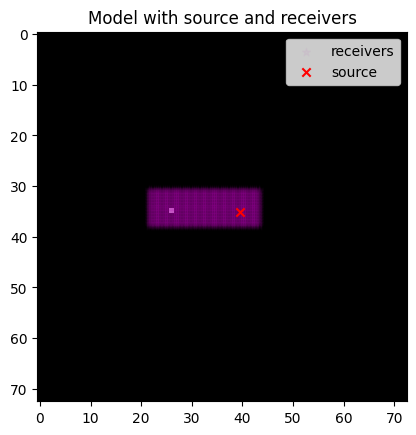

In [10]:
plt.scatter(receiver_is[:,1], receiver_is[:,0], c="m", marker="*", label="receivers", alpha=0.03)
plt.scatter(src_idx[1], src_idx[0], c="r", marker="x", label="source")
plt.imshow(true_model,cmap='grey')
plt.legend()
plt.title("Model with source and receivers")
plt.show()

In [11]:
# make a shot gather with the x axis being the y position
# sorte the trace by y position
source_x, source_y = src_idx
receiver_x, receiver_y = receiver_is[:,0], receiver_is[:,1]
sorted_indices_y = np.argsort(receiver_y)
sorted_offsets_y = receiver_y[sorted_indices_y]
sorted_traces_y = seis[:, sorted_indices_y]
n_traces_y = sorted_traces_y.shape[1]
n_samples_y = sorted_traces_y.shape[0]

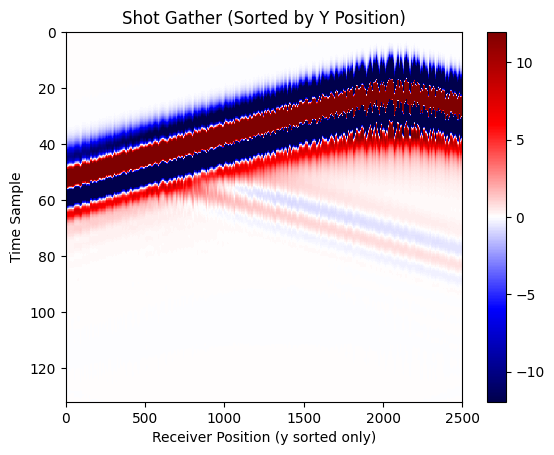

In [13]:
# plot the sorted traces as a shot gather
plt.imshow(
    jnp.flipud((sorted_traces_y)),
    aspect='auto',
    extent=[0, n_traces_y, 0, n_samples_y],
    cmap='seismic',
    vmin=-np.amax(np.abs(sorted_traces_y))/20,
    vmax=np.amax(np.abs(sorted_traces_y))/20
)

plt.gca().invert_yaxis()
plt.colorbar()
plt.title('Shot Gather (Sorted by Y Position)')
plt.xlabel('Receiver Position (y sorted only)')
plt.ylabel('Time Sample')
plt.show()

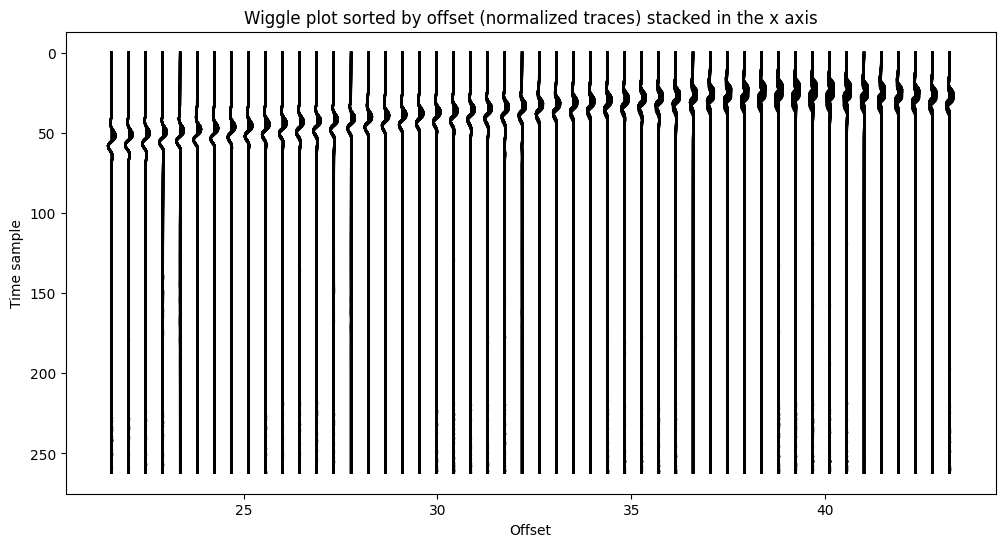

In [177]:
scale = 0.1  # Adjust for visual clarity
plt.figure(figsize=(12, 6))
for i in range(n_traces_y):
    trace = sorted_traces_y[:, i]
    norm_trace = trace / (np.max(np.abs(trace)) + 1e-12)
    # norm_trace = trace
    plt.plot(norm_trace * scale + sorted_offsets_y[i], np.arange(n_samples), color='k')
    plt.fill_betweenx(np.arange(n_samples), sorted_offsets_y[i], norm_trace * scale + sorted_offsets_y[i], where=(norm_trace > 0), color='k', alpha=0.5)
plt.gca().invert_yaxis()
plt.xlabel('Offset')
plt.ylabel('Time sample')
plt.title('Wiggle plot sorted by offset (normalized traces) stacked in the x axis')
plt.show()


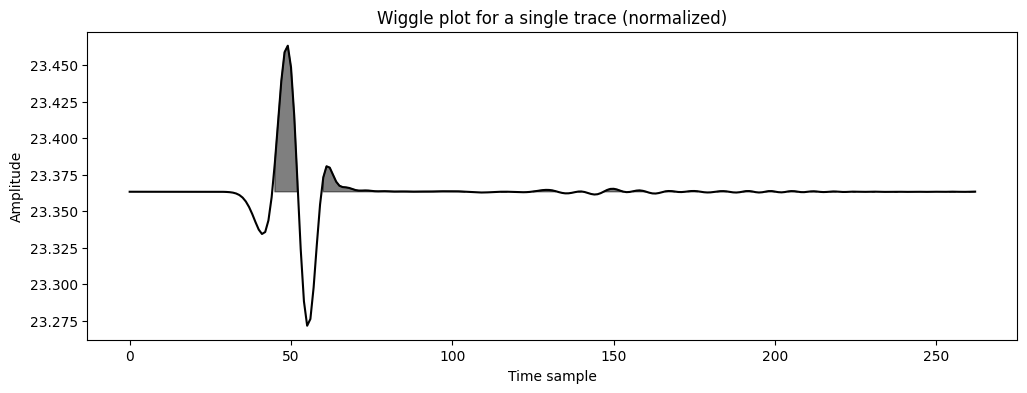

In [184]:
# plot only 1 wiggle in landscape view (time on x-axis, amplitude on y-axis)
plt.figure(figsize=(12, 4))
i = 200  # index of the trace to plot
trace = sorted_traces_y[:, i]
norm_trace = trace / (np.max(np.abs(trace)) + 1e-12)
plt.plot(np.arange(n_samples), norm_trace * scale + sorted_offsets_y[i], color='k')
plt.fill_between(np.arange(n_samples), sorted_offsets_y[i], norm_trace * scale + sorted_offsets_y[i], where=(norm_trace > 0), color='k', alpha=0.5)
plt.xlabel('Time sample')
plt.ylabel('Amplitude')
plt.title('Wiggle plot for a single trace (normalized)')
plt.show()


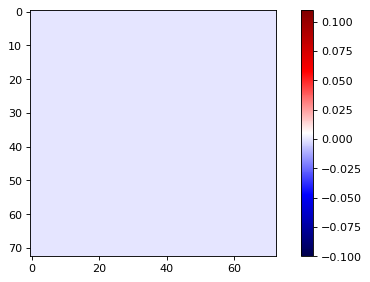

In [40]:
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation, PillowWriter

SUBSAMPLE = 2          # use every 2nd frame (tweak to taste)
FPS = 10               # playback rate
DPI = 80               # lower DPI -> smaller/faster GIF

fig, ax = plt.subplots(figsize=(8, 4), dpi=DPI)
im = ax.imshow(
    wavefields_test[0],
    vmin=-0.1, vmax=0.11,
    cmap='seismic',
    aspect='equal',
    animated=True,      # important for blitting
)
# Colorbars slow blitting; comment out if you can live without it in the GIF.
plt.colorbar(im, ax=ax)

def update(i):
    im.set_data(wavefields_test[i])
    return (im,)

frames = range(0, wavefields_test.shape[0], SUBSAMPLE)

# Try blit=True first; if you keep the colorbar, blit=False may actually be faster.
ani = FuncAnimation(fig, update, frames=frames, blit=True)
ani.save('wavefield.gif', writer=PillowWriter(fps=FPS))